# Shapiq for Data Valuation
On this page we demonstrate two examples for using Shapiq for Data valuation.
The first example demonstrates this for a synthetic dataset, and the second for a real dataset.

In data valuation we are interested given a training and testing dataset to evaluate the contribution of each training point to the model's performance on the test data.

## Synthetic Data
In this example we generate a synthetic classification dataset with 2 features, and 10 samples.

In [488]:
import numpy as np
import matplotlib.pyplot as plt
import shapiq

# Vector Graphics
%matplotlib inline
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

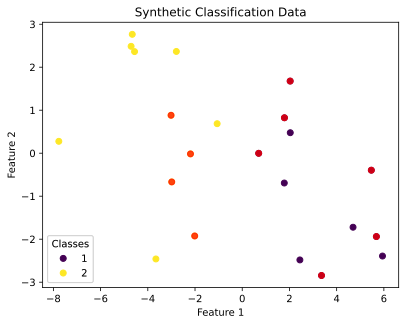

In [489]:
def plot_synthetic_data(ax, X_train, y_train, X_test, y_test, title):
    ax.set_title(title)
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, label="Test Points")
    ax.scatter(X_test[:, 0], X_test[:, 1], c="red", label="Test Points", alpha=0.7)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


# Meta information
n_samples = 11
n_classes = 2
classes = list(range(1, n_classes + 1))
random_state = 1337
np.random.seed(random_state)

# parameters for toy data
means = [(3, 0), (-3, 0)]
covs = [np.diag([3, 2]), np.diag([3, 3.5])]

# Construct the dataset
X = np.vstack(
    [np.random.multivariate_normal(mean, cov, n_samples) for mean, cov in zip(means, covs)]
)
y = np.hstack([np.full(n_samples, i) for i in classes])

# Build training and test set
n_samples_to_select = 10
random_indices = np.random.choice(X.shape[0], n_samples_to_select, replace=False)
X_test, y_test = X[random_indices], y[random_indices]
X_train, y_train = np.delete(X, random_indices, axis=0), np.delete(y, random_indices, axis=0)
fig, ax = plt.subplots()

plot_synthetic_data(ax, X_train, y_train, X_test, y_test, "Synthetic Classification Data")

To apply `shapiq` approximators we need to reformulate the task of data valuation into a cooperative game.
For our example we define as test points (red), and as players the training points (yellow and violett).
The value of a coalition is then the accuracy the model achieves on the test points given the training points in the coalition.


In [490]:
class SyntheticDataValuation(shapiq.Game):
    """The synthetic data valuation tasked modeled as a cooperative game.
    Args:
        classifier: A classifier object that has the methods fit and score.
        n_players: The number of players in the game.
        X_test: The test data.
        y_test: The test labels.
    """

    def __init__(self, classifier, n_players, X_train, y_train, X_test, y_test):
        self.classifier = classifier
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        empty_coalition_value = np.zeros((1, n_players), dtype=bool)
        self.normalization_value = float(self.value_function(empty_coalition_value)[0])
        super().__init__(n_players, normalization_value=self.normalization_value)

    def value_function(self, coalitions: np.ndarray) -> np.ndarray:
        """Compute the value of the coalitions.
        Args:
            coalitions: A numpy matrix of shape (n_coalitions, n_players)

        Returns:
            A vector of the value of the coalition
        """
        values = []
        for coalition in coalitions:
            tmp_X_train = self.X_train[coalition]
            tmp_y_train = self.y_train[coalition]
            if len(tmp_X_train) == 0:
                # If the coalition is empty, the value is zero
                value = 0
            else:
                unique_targets = np.unique(tmp_y_train)
                if len(unique_targets) == 1:
                    # If we only have one class present in training data, we predict this class
                    value = np.mean((self.y_test == unique_targets[0]))
                else:
                    # We have at least two classes, we fit the classifier
                    self.classifier.fit(tmp_X_train, tmp_y_train)
                    value = self.classifier.score(self.X_test, self.y_test)

            values.append(value)

        return np.array(values, dtype=float)

Now with the given game we choose `LinearSVM()` as classifier and compute the value of the full and empty coalition.

In [491]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
n_players = X_train.shape[0]
data_valuation_game = SyntheticDataValuation(
    classifier=classifier,
    n_players=n_players,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

full_coalition = np.ones((1, n_players), dtype=bool)
empty_coalition = np.zeros((1, n_players), dtype=bool)
print("Full coalition value: ", data_valuation_game(full_coalition)[0])
print("Empty coalition value: ", data_valuation_game(empty_coalition)[0])

Full coalition value:  1.0
Empty coalition value:  0.0


## Computing Shapley Values
Now we can compute the Shapley values for the data valuation game.
Intuitively, the Shapley values should all be positive as each training point makes the model more aware of the natural boundarie between the two classes.

In [492]:
# Compute Shapley values with the ShapIQ approximator for the game function
approximator = shapiq.SHAPIQ(n=n_players, max_order=1, index="SV")
sv_values = approximator.approximate(budget=2**n_players, game=data_valuation_game)
sv_values.dict_values

{(): 0.0,
 (0,): 0.13555555555555557,
 (1,): 0.10999999999999996,
 (2,): 0.13555555555555546,
 (3,): 0.11666666666666667,
 (4,): 0.1166666666666666,
 (5,): 0.05936507936507933,
 (6,): 0.05936507936507936,
 (7,): 0.056031746031746,
 (8,): 0.056031746031746016,
 (9,): 0.05603174603174599,
 (10,): 0.04269841269841263,
 (11,): 0.05603174603174599}

## Corrupting the Data
We can now investigate the impact of corrupting the data on the Shapley values.
Currently the Shapley values are less interesting as we have a clear boundary between the two classes.
If we now corrupt the data by adding noise to the labels, the Shapley values should change and identify the corrupted samples.

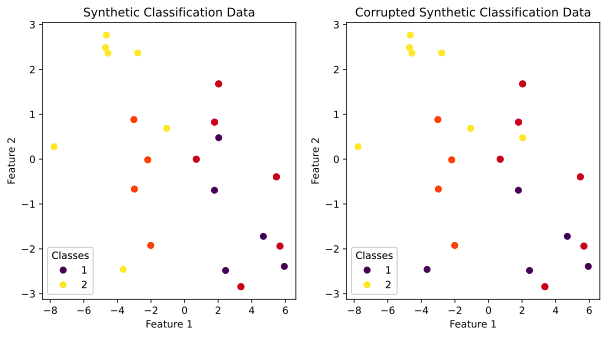

In [493]:
from matplotlib import patches

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plot_synthetic_data(ax[0], X_train, y_train, X_test, y_test, "Synthetic Classification Data")

corrupted_X_train = X_train.copy()
corruped_y_train = y_train.copy()

corruped_y_train[5] = 1
corruped_y_train[2] = 2
plot_synthetic_data(
    ax[1],
    corrupted_X_train,
    corruped_y_train,
    X_test,
    y_test,
    "Corrupted Synthetic Classification Data",
)

In [494]:
data_valuation_game = SyntheticDataValuation(
    classifier=classifier,
    n_players=n_players,
    X_train=corrupted_X_train,
    y_train=corruped_y_train,
    X_test=X_test,
    y_test=y_test,
)

# Compute Shapley values with the ShapIQ approximator for the game function
approximator = shapiq.SHAPIQ(n=n_players, max_order=1, index="SV")
sv_values = approximator.approximate(budget=2**n_players, game=data_valuation_game)
sv_values.dict_values

{(): 0.0,
 (0,): 0.09477994227994223,
 (1,): 0.08918470418470417,
 (2,): -0.21544733044733047,
 (3,): 0.10323232323232323,
 (4,): 0.11061327561327558,
 (5,): -0.041558441558441586,
 (6,): 0.051883116883116885,
 (7,): 0.09049422799422802,
 (8,): 0.04795454545454547,
 (9,): 0.04835137085137084,
 (10,): 0.07216089466089465,
 (11,): 0.04835137085137085}

With both corrupted samples identified by the Shapley values, we can now remove them from the training data and our model should perform better on the test data.

In [495]:
classifier.fit(corrupted_X_train, corruped_y_train)
print("Accuracy on test data before removing corrupted samples: ", classifier.score(X_test, y_test))

cleaned_X_train = np.delete(corrupted_X_train, [5, 2], axis=0)
cleaned_y_train = np.delete(corruped_y_train, [5, 2], axis=0)
classifier.fit(cleaned_X_train, cleaned_y_train)
print("Accuracy on test data after removing corrupted samples: ", classifier.score(X_test, y_test))

Accuracy on test data before removing corrupted samples:  0.5
Accuracy on test data after removing corrupted samples:  1.0


To verify this as sensible we plot the decision boundary of the `LinearSVM` classifier for the corrupted and cleaned training data and the corresponding test data.

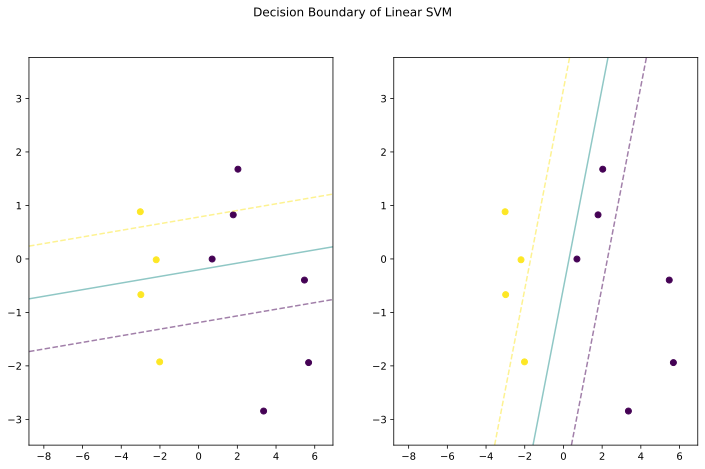

In [496]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary(ax, classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
    DecisionBoundaryDisplay.from_estimator(
        classifier,
        X_train,
        plot_method="contour",
        ax=ax,
        levels=[-1, 0, 1],
        linestyles=["--", "-", "--"],
        alpha=0.5,
    )


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
fig.suptitle("Decision Boundary of Linear SVM")
# Plot the decision boundary of the model with corrupted samples
plot_decision_boundary(ax[0], classifier, corrupted_X_train, corruped_y_train, X_test, y_test)

# Plot the decision boundary of the model with removed corrupted samples
plot_decision_boundary(ax[1], classifier, cleaned_X_train, cleaned_y_train, X_test, y_test)
plt.show()